# Attention is all you need. Трансформеры.

## Библиотеки

In [ ]:
!pip install --quiet -U dvc[gdrive]==1.11.1 transformers==4.0.0 sentencepiece

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import torch
import scipy
from transformers import AutoModel, AutoTokenizer
from transformers import MarianMTModel, MarianTokenizer

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Выборка паралельных текстов

In [ ]:
!dvc get https://github.com/andriygav/MachineLearningSeminars sem18/data/Wikipedia.en-ru.ru
!dvc get https://github.com/andriygav/MachineLearningSeminars sem18/data/Wikipedia.en-ru.en

In [4]:
with open('./Wikipedia.en-ru.ru') as f:
    ru_all_texts = f.read().splitlines()

with open('./Wikipedia.en-ru.en') as f:
    en_all_texts = f.read().splitlines()

In [5]:
ru_texts = []
en_texts = []

for ru_text, en_text in zip(ru_all_texts, en_all_texts):
    if len(ru_text) < 100 and len(en_text) < 100:
        ru_texts.append(ru_text.lower())
        en_texts.append(en_text.lower())

In [6]:
len(ru_texts), len(en_texts)

(306887, 306887)

## Код для обучения

In [7]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    output = model(x_batch.to(model.device), y_batch.to(model.device))
    
    loss = loss_function(output.transpose(1,2), 
                         y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [8]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [9]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True, pin_memory=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size>0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

## Модель внимания в рекурентных моделях

### Определение модели

In [10]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, batch_first=True)

    def forward(self, input):
        r'''
        :param input: тензор размера batch_size x seq_len --- список токенов

        '''
        act = self.embedding(input)
        act, hidden = self.lstm(act)
        return act, hidden

In [11]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention = torch.nn.MultiheadAttention(emb_dim, 1)

        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, batch_first=True)

        self.linear = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, encoder_outputs, hidden):
        r'''
        :param input: тезор размера batch_size x seq_len
        '''
        act = self.embedding(input)

        act, _ = self.attention(act.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1))

        act = act.transpose(0, 1)
        act, hidden = self.lstm(act, hidden)
        return self.linear(act), hidden

In [12]:
class seq2seq(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(seq2seq, self).__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim)

    def forward(self, input, decoder_input=None, max_seq_len=64):
        r'''
        '''
        encoder_output, hidden = self.encoder(input)

        if decoder_input is None:
            translated_scores = torch.zeros(len(input), 
                                            max_seq_len, 
                                            self.vocab_size).to(self.device)
            translated_scores[:, 0, input[:, 0]] = 1.
            for i in range(1, max_seq_len):
                translated_scores[:, i:i+1], hidden = self.decoder(
                    torch.argmax(translated_scores[:, i-1:i], axis=-1), 
                    encoder_output, 
                    hidden)
        else:
            translated_scores, _ = self.decoder(
                decoder_input, encoder_output, hidden)

        return translated_scores


### Инициализация модели

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased', 
                                          verbose=False)
tokenizer.vocab_size

105879

In [14]:
en_texts_tensors = tokenizer(en_texts[:20000], 
                             return_tensors='pt', max_length=64, padding=True)
ru_texts_tensors = tokenizer(ru_texts[:20000], 
                             return_tensors='pt', max_length=64, padding=True)

In [15]:
dataset_train_pt = torch.utils.data.TensorDataset(
    en_texts_tensors['input_ids'][:19000], ru_texts_tensors['input_ids'][:19000])
dataset_test_pt = torch.utils.data.TensorDataset(
    en_texts_tensors['input_ids'][19000:], ru_texts_tensors['input_ids'][19000:])

In [16]:
model = seq2seq(tokenizer.vocab_size)
model.to(device)

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(105879, 30)
    (lstm): LSTM(30, 30, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(105879, 30)
    (attention): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=30, out_features=30, bias=True)
    )
    (lstm): LSTM(30, 30, batch_first=True)
    (linear): Linear(in_features=30, out_features=105879, bias=True)
  )
)

In [17]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam

In [ ]:
trainer(count_of_epoch=15, 
        batch_size=64, 
        dataset=dataset_train_pt,
        model=model, 
        loss_function=loss_function,
        optimizer = optimizer,
        lr=0.001,
        callback=None)

In [70]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_ru['input_ids'].to(model.device), max_seq_len=10), 
        axis=-1)
tokenizer.decode(answer[0])

'. на [SEP]с [SEP]с [SEP] [SEP] [SEP] в'

In [71]:
with torch.no_grad():
    encoder_outputs, _ = model.encoder(
        tokens_en['input_ids'].to(model.device))

    decoder_embedding = model.decoder.embedding(
        tokens_ru['input_ids'].to(model.device))

    act, act_weight = model.decoder.attention(
        decoder_embedding.transpose(0, 1), 
        encoder_outputs.transpose(0, 1), 
        encoder_outputs.transpose(0, 1))

In [72]:
attention_frame = pd.DataFrame(
    act_weight[0].cpu().numpy(),
    index=tokenizer.convert_ids_to_tokens(
        tokens_ru['input_ids'][0].cpu().numpy()),
    columns=tokenizer.convert_ids_to_tokens(
        tokens_en['input_ids'][0].cpu().numpy()))

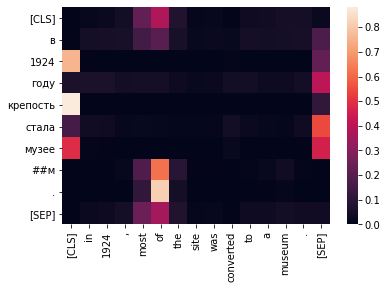

In [74]:
sns.heatmap(data=attention_frame)

plt.show()

## Трансформер 

### Определение модели

In [75]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Encoder, self).__init__()

        self.layers = torch.nn.Sequential()
        
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention1 = torch.nn.MultiheadAttention(emb_dim, 1)
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.attention2 = torch.nn.MultiheadAttention(hidden_dim, 1)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)


    def forward(self, input):
        r'''
        :param input: тензор размера batch_size x seq_len --- список токенов

        '''
        input = input.transpose(0, 1)
        act = self.embedding(input)
        act, _ = self.attention1(act, act, act)
        act = self.relu(act)
        act = self.linear1(act)
        act = self.relu(act)
        act, _ = self.attention2(act, act, act)
        act = self.relu(act)
        act = self.linear2(act)
        return act.transpose(0, 1)

In [76]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention = torch.nn.MultiheadAttention(emb_dim, 1)
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.relu = torch.nn.ReLU()

        self.attention2 = torch.nn.MultiheadAttention(hidden_dim, 1)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)

        self.linear = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, encoder_outputs):
        r'''
        :param input: тезор размера batch_size x seq_len
        '''
        input = input.transpose(0, 1)
        act = self.embedding(input)

        act, _ = self.attention(act, 
                                encoder_outputs.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1))
        
        act = self.relu(act)
        act = self.linear1(act)
        act = self.relu(act)
        act, _ = self.attention2(act, 
                                 encoder_outputs.transpose(0, 1), 
                                 encoder_outputs.transpose(0, 1))
        act = self.relu(act)
        act = self.linear2(act)

        return self.linear(act).transpose(0, 1)

In [80]:
class seq2seq(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(seq2seq, self).__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim)

    def forward(self, input, decoder_input=None, max_seq_len=64):
        r'''
        '''
        encoder_output = self.encoder(input)

        if decoder_input is None:
            translated_scores = torch.zeros(len(input), 
                                            max_seq_len, 
                                            self.vocab_size).to(self.device)
            translated_scores[:, 0, input[:, 0]] = 1.
            for i in range(1, max_seq_len):
                translated_scores[:, i:i+1] = self.decoder(
                    torch.argmax(translated_scores, axis=-1), 
                    encoder_output)[:, i:i+1]
        else:
            translated_scores = self.decoder(
                decoder_input, encoder_output)

        return translated_scores


### Инициализация модели

In [84]:
model = seq2seq(tokenizer.vocab_size)
model.to(device)

seq2seq(
  (encoder): Encoder(
    (layers): Sequential()
    (embedding): Embedding(105879, 30)
    (attention1): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (relu): ReLU()
    (attention2): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=30, out_features=30, bias=True)
    )
    (linear2): Linear(in_features=30, out_features=30, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(105879, 30)
    (attention): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (relu): ReLU()
    (attention2): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=30, out_features=30, bias=True)
    )
    (linear2): Linear(in_features=30, out_features=30, bias=True)
    (linear): Linear(in_features=30, out_features

In [85]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_ru['input_ids'].to(model.device)), 
        axis=-1)
tokenizer.decode(answer[0])

'##綸綸綸綸綸綸綸綸綸綸'

In [86]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam

In [ ]:
trainer(count_of_epoch=5, 
        batch_size=64, 
        dataset=dataset_train_pt,
        model=model, 
        loss_function=loss_function,
        optimizer = optimizer,
        lr=0.001,
        callback=None)

In [88]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_ru['input_ids'].to(model.device)), 
        axis=-1)
tokenizer.decode(answer[0])

'##аааааааааа'

## Переводчик Tensor2Tensor

In [8]:
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ru-en')
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ru-en')
model.to(device)

MarianMTModel(
  (model): BartModel(
    (shared): Embedding(62518, 512, padding_idx=62517)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(62518, 512, padding_idx=62517)
      (embed_positions): SinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): Attention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): EncoderLayer

In [17]:
batch_x = tokenizer.prepare_seq2seq_batch(src_texts=['Привет мир, меня зовут Трансформер'], return_tensors="pt")

In [18]:
tokenizer.batch_decode(model.generate(**batch_x.to(device)))

['<pad> Hey, world, my name is Transformer.']

## Токенизация BPE (Byte Pair Encoding)

In [20]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE', 
                                          verbose=False)
tokenizer.vocab_size

501153

In [29]:
tokenizer.tokenize('Hello Mathematic, my Name is Andrey, how are you?')

['Hello',
 'Math',
 '##emat',
 '##ic',
 ',',
 'my',
 'Name',
 'is',
 'Andrey',
 ',',
 'how',
 'are',
 'you',
 '?']

## BERT (Bidirectional Encoder Representations from Transformers)

In [31]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          verbose=False)
model = AutoModel.from_pretrained('bert-base-multilingual-cased')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

### Архитектура BERT
Разделяется условно на три части:

- Tokens Embedding
- Self-Attention
- Pooler

### Математическая модель BERT
Пусть задано множество токенов:
$$
\mathcal{I} = \{\mathbf{i}| \mathbf{i} = [0, \cdots, 0, 1, 0,  \cdots, 0]^{\mathsf{T}}\}
$$

Задано множество предложений и множество типов токенов в предложении:
$$
\mathcal{S} = \mathcal{I}^n, \quad \mathcal{T} = \{[0,1]^{\mathsf{T}}, [1,0]^{\mathsf{T}}\}^n
$$

Отображения:
$$
BM_1: \mathbb{R}^{n\times L}\times \mathbb{R}^{2\times L} \to \mathbb{R}^{n \times l}
$$
$$
BM_2: \mathbb{R}^{n\times L}\times \mathbb{R}^{2\times L} \to \mathbb{R}^{1 \times l}
$$

Суперпозиция отображений:
$$
BM_1 = BL_m \circ \cdots \circ BL_1 \circ BSE
$$
$$
BM_2 = BP \circ BL_m \circ \cdots \circ BL_1 \circ BSE
$$

### Математическая модель BERT: BSE

Функция $BSE$:
$$
BSE:\mathbb{R}^{n\times L} \times \mathbb{R}^{n\times 2} \to \mathbb{R}^{n\times l}.
$$

Для произвольной матрицы $\mathbf{s} \in \mathcal{S} \subset \mathbb{R}^{n\times L}$ и матрицы $\mathbf{t} \in \mathcal{T}\subset \mathbb{R}^{n\times 2}$ отображение $BSE$ принимает следующий вид:
$$
BSE\bigr(\mathbf{s}, \mathbf{t}\bigr) = \frac{\mathbf{h}_{bse} - \mathsf{E}\mathbf{h}_{bse}}{\sqrt{\mathsf{D}\mathbf{h}_{bse}+\varepsilon}}\cdot\textbf{w}_1 + \textbf{w}_2, \quad \mathbf{h}_{bse} = \mathbf{s}\mathbf{W}_1 + \mathbf{1}_{n\times n}\mathbf{W}_2 + \mathbf{t}\mathbf{W}_3,
$$
где $\mathbf{W}_1 \in \mathbb{R}^{L\times l},~\mathbf{W}_2 \in \mathbb{R}^{n\times l},~\mathbf{W}_3 \in \mathbb{R}^{2\times l}.$

Функция $BSE$ имеет настриваемые параметры: $\mathbf{W}_1, \mathbf{W}_2, \mathbf{W}_3, \mathbf{w}_1, \mathbf{w}_2.$

Результат работы функции $BSE$ обозначим:
$$
\mathbf{h}_0 = BSE\bigr(\mathbf{s}, \mathbf{t}\bigr),
$$
где $\mathbf{h} \in \mathbb{R}^{n\times l}.$

### Математическая модель BERT: BL

Функция $BL$:
$$
    BL: \mathbb{R}^{n\times l} \to \mathbb{R}^{n\times l}.
$$
Для матрицы $\mathbf{h} \in \mathbb{R}^{n\times l}$ BL принимает следующий вид:
$$
    BL_q\bigr(\mathbf{h}\bigr) = \frac{\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a} - \mathsf{E}\left(\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a}\right)}{\sqrt{\mathsf{D}\left(\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a}\right)+\varepsilon}}\cdot\textbf{w}_{3+4q} + \textbf{w}_{4+4q},
$$
$$
\mathbf{u} = \sigma\bigr(\mathbf{a}\mathbf{W}_{4+6q}\bigr), \quad \mathbf{a} = \frac{\mathbf{c}\mathbf{W}_{5+6q} - \mathsf{E}\mathbf{c}\mathbf{W}_{5+6q}}{\sqrt{\mathsf{D}\mathbf{c}\mathbf{W}_{5+6q}+\varepsilon}}\cdot\textbf{w}_{5+4q} + \textbf{w}_{6+4q}
$$
$$
\mathbf{c} = [\mathbf{c}_1, \cdots \mathbf{c}_{r_2}]
$$
$$
\mathbf{c}_j = \text{softmax}\bigr(\mathbf{h}\mathbf{W}^{j}_{6+6q}\odot\mathbf{h}\mathbf{W}^{j}_{7+6q}\bigr)\odot\mathbf{h}\mathbf{W}^{j}_{8+6q}
$$
где для всех $q$ матрицы $\mathbf{W}^{j}_{6+6q}, \mathbf{W}^{j}_{7+6q}, \mathbf{W}^{j}_{6+6q} \in \mathbb{R}^{l \times r}$, для всех $j$ матрицы $\mathbf{c}_j \in \mathbb{R}^{n\times r}$, для всех $q$ матрицы $\mathbf{W}^{j}_{5+6q} \in \mathbb{R}^{l \times l}, \mathbf{W}^{j}_{4+6q} \in \mathbb{R}^{l \times p}, \mathbf{W}^{j}_{3+6q} \in \mathbb{R}^{p \times l}$, матрица $\mathbf{c}, \mathbf{a} \in \mathbb{R}^{n \times l}$, матрица $\mathbf{u} \in \mathbb{R}^{n \times p}$.

Настраиваемые параметры: $\mathbf{W}^{j}_{3+6q}, \mathbf{W}^{j}_{4+6q}, \mathbf{W}^{j}_{5+6q}, \mathbf{W}^{j}_{6+6q}, \mathbf{W}^{j}_{7+6q}, \mathbf{W}^{j}_{8+6q}, \textbf{w}_{3+4q}, \textbf{w}_{4+4q}, \textbf{w}_{5+4q}, \textbf{w}_{6+4q}$

Результат работы функции $BL_q$:
$$
\forall q \in \{1, \cdots m\} \quad \mathbf{h}_{q} = BL_q\bigr(\mathbf{h}_{q-1}\bigr).
$$


### Математическая модель BERT: BP

Функция $BP$:
$$
    BP: \mathbb{R}^{n\times l} \to \mathbb{R}^{n\times l}.
$$
Для матрицы $\mathbf{h}_{m} \in \mathbb{R}^{n \times l}$ BP принимает следующий вид:
$$
BP\bigr(\mathbf{h}_{m}\bigr) = \sigma\bigr(\mathbf{h}_m^{1}\mathbf{W}_{9+6m}\bigr),
$$
где $\mathbf{h}_m^{1}$ первая строка матрицы $\mathbf{h}_{m}$, а матрица $\mathbf{W}_{9+6m} \in \mathbb{R}^{l\times l}$

Функция $BP$ имеет настраиваемые параметры $\mathbf{W}_{9+6m}$

Результат работы функции $BP$:
$$
\mathbf{h} = BP\bigr(\mathbf{h}_m\bigr).
$$

### Снова суперпозиция

Вернемся к суперпозициям $BM_1, BM_2$:
$$
\mathbf{h} = BP\bigr(\mathbf{h}_m\bigr), \quad\mathbf{h}_q = BM\bigr(\mathbf{h}_{q-1} \bigr), \quad \mathbf{h}_0 = BSE\bigr(\mathbf{s}, \mathbf{t}\bigr)
$$

Получаем вектор эмбедингов слов:
$$
BM_1\bigr(\mathbf{s}, \mathbf{t}\bigr) = \mathbf{h}_m,
$$
Получаем вектор эмбединга предложения:
$$
BM_2\bigr(\mathbf{s}, \mathbf{t}\bigr) = \mathbf{h}
$$

### Multitask Learning

LM модель:
$$
\mathbf{v} = \text{softmax}\bigr(\mathbf{h}_m\mathbf{W}_{LM}\bigr),
$$
где $\mathbf{W}_{LM} \in \mathbb{R}^{l \times L}$, а $\mathbf{v}$ это вероятность каждого токена.

NSP модель:
$$
z = \sigma\bigr(\mathbf{h}\mathbf{W}_{NSP}\bigr),
$$
где $\mathbf{W}_{NSP} \in \mathbb{R}^{l \times 1}$, а $z$ это вероятность класса $1$.

Функция ошибки:
$$
L\bigr(\mathbf{S}, \mathbf{y}\bigr) = \sum_{\mathbf{s}_i, \mathbf{t}_i \in \mathbf{S}}CrossEntropy\bigr(\mathbf{v}_i, \mathbf{s}_i\bigr) + \sum_{\mathbf{s}_i, \mathbf{t}_i \in \mathbf{S}, y_i \mathbf{y}}CrossEntropyLoss\bigr(z_i, y_i\bigr)
$$
Задача оптимизации:
$$
L\bigr(\mathbf{S}, \mathbf{y}\bigr) \to \min_{\mathbf{W}_{all}}
$$

Все параметры:
$$
\mathbf{W}_{all} = [\mathbf{W}_{LM}, \mathbf{W}_{NSP}, \mathbf{W}_{9+6m}
\mathbf{W}^{j}_{3+6q}, \mathbf{W}^{j}_{4+6q}, \mathbf{W}^{j}_{5+6q}, \mathbf{W}^{j}_{6+6q}, \mathbf{W}^{j}_{7+6q}, \mathbf{W}^{j}_{8+6q}, \textbf{w}_{3+4q}, \textbf{w}_{4+4q}, \textbf{w}_{5+4q}, \textbf{w}_{6+4q},
\mathbf{W}_1, \mathbf{W}_2, \mathbf{W}_3, \mathbf{w}_1, \mathbf{w}_2]
$$

In [48]:
tokens = tokenizer(['Hello World', 'Andrey Grabovoy'], return_tensors='pt', padding=True)

with torch.no_grad():
    output = model(**tokens.to(device))

In [49]:
tokens['input_ids']

tensor([[  101, 31178, 10315,   102,     0,     0,     0],
        [  101, 25188, 10157, 61020, 28194, 10157,   102]], device='cuda:0')

In [51]:
output[0].shape, output[1].shape

(torch.Size([2, 7, 768]), torch.Size([2, 768]))

In [52]:
tokens

{'input_ids': tensor([[  101, 31178, 10315,   102,     0,     0,     0],
        [  101, 25188, 10157, 61020, 28194, 10157,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

## Модель LaBSE (Language-agnostic BERT Sentence Embedding)

In [53]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE', 
                                          verbose=False)
model = AutoModel.from_pretrained('sentence-transformers/LaBSE')
model.to(device)

Downloading:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(501153, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [65]:
tokens = tokenizer(['Moscow Institute of Physics and Technology', 
                    'Московский Физико-Технический Институт', 
                    'Московский Государственный Университет', 
                    'Moscow State University'], 
                   return_tensors='pt', padding=True)

with torch.no_grad():
    output = model(**tokens.to(device))

sentence_embeding = output[1].cpu().numpy()

In [66]:
sentence_embeding.shape

(4, 768)

In [69]:
frame = pd.DataFrame(np.round(
    scipy.spatial.distance.cdist(sentence_embeding, sentence_embeding, 
                                 metric='cosine'), 2))


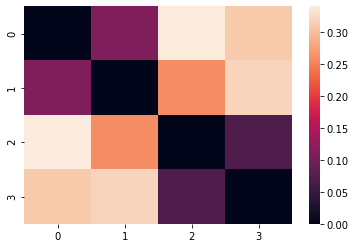

In [70]:
sns.heatmap(data=frame)

plt.show()